# 43-modeling-ARIMA

> This notebook uses ARIMA to predict iPhone 13 claims data for March 2023. The notebook is strictly only using iPhone 13 data. The purpose of the notebook is to understand how to use ARIMA and get some ideas on how to apply ARIMA when using iPhone 14. This notebook was shown during the team's peer review meeting. As discussed, the notebook though focused on iPhone 13 will be pushed onto GitHub.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm

import os

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Load the data

In [2]:
#Constants/globals
os.chdir('/data/p_dsi/teams2023/team9/')
os.getcwd()

'/gpfs52/data/p_dsi/teams2023/team9'

In [4]:
#load the data
data = pd.read_csv("Asurion_clean_data_feature_set.csv")
display(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   phone model       11684 non-null  object
 1   phone size        11684 non-null  object
 2   phone color       11684 non-null  object
 3   claim             11684 non-null  int64 
 4   weeks_monday      11684 non-null  object
 5   month             11684 non-null  object
 6   year              11684 non-null  int64 
 7   season            11684 non-null  object
 8   quarter           11684 non-null  object
 9   Holidays_Boolean  11684 non-null  bool  
 10  company           11684 non-null  object
 11  model_group       11684 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 1015.6+ KB


None

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group
0,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
1,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
2,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
3,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
4,apple iphone 11,128gb,white,91,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
5,apple iphone 11,128gb,yellow,5,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
6,apple iphone 11,256gb,black,24,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
7,apple iphone 11,256gb,green,3,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
8,apple iphone 11,256gb,purple,7,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
9,apple iphone 11,256gb,red,9,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11


   weeks_monday  claim
0    2021-11-15      2
1    2021-11-22      3
2    2021-11-29      6
3    2021-12-06      2
4    2021-12-13     10
..          ...    ...
61   2023-01-16   3828
62   2023-01-23   4090
63   2023-01-30   3740
64   2023-02-06   4270
65   2023-02-13    847

[66 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   weeks_monday  66 non-null     object
 1   claim         66 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


None

<AxesSubplot:>

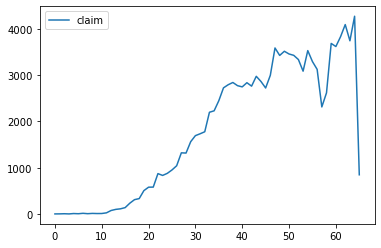

In [5]:
iphone13 = data[data["model_group"] == "iphone 13"]
result_iphone_13 = iphone13.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})


print(result_iphone_13)
display(result_iphone_13.info())
result_iphone_13.plot()

,weeks_monday,claim
0,2021-11-15,2
1,2021-11-22,3
2,2021-11-29,6
3,2021-12-06,2
4,2021-12-13,10
...,...,...
60,2023-01-09,3616
61,2023-01-16,3828
62,2023-01-23,4090
63,2023-01-30,3740


Text(0.5, 1.0, 'iPhone 13 Claims Data without Outlier')

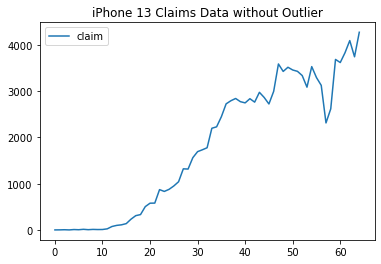

In [6]:
# Removing last data point as recommended by professor, we have reason to think that the data is an outlier due to
# the data being incomplete

result_iphone_13 = result_iphone_13[:65]

display(result_iphone_13)

result_iphone_13.plot()
plt.title("iPhone 13 Claims Data without Outlier")

In [7]:
result_iphone_13['weeks_monday'] = pd.to_datetime(result_iphone_13['weeks_monday'])
result_iphone_13.set_index('weeks_monday', inplace = True)
# Changed up result_iphone_13 so it can use the weeks_monday

/tmp/ipykernel_28412/1912083778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_iphone_13['weeks_monday'] = pd.to_datetime(result_iphone_13['weeks_monday'])


In [8]:
# Making a copy of the data for the v2 ARIMA/SARIMA model
result_iphone_13_v2 = result_iphone_13.copy()

# Making a copy of the data for the manual ARIMA/SARIMA model version example
result_iphone_13_vmanual = result_iphone_13.copy()

display(result_iphone_13.head())
result_iphone_13.info()

,claim
weeks_monday,
2021-11-15,2
2021-11-22,3
2021-11-29,6
2021-12-06,2
2021-12-13,10


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2021-11-15 to 2023-02-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   claim   65 non-null     int64
dtypes: int64(1)
memory usage: 1.0 KB


Text(0.5, 1.0, 'iPhone 13 Claims Data')

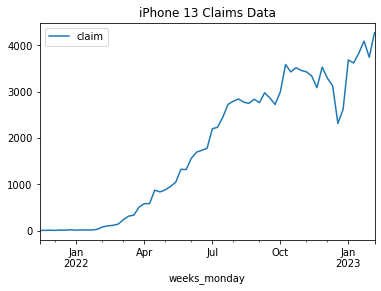

In [9]:
result_iphone_13.plot()
plt.title("iPhone 13 Claims Data")
# Plot has x-axis as weeks_monday

## ARIMA Model - Manual Version
> Note that the resulting values to pick for p, d, q, through the manual version ends up being the same as using auto_arima. Thus, I think moving forwards we can generally use auto_arima for the calculations

/home/leet23/.local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


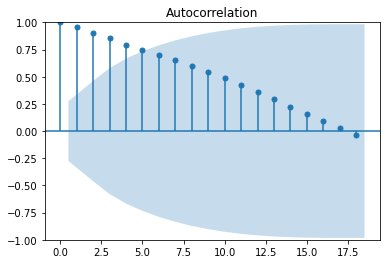

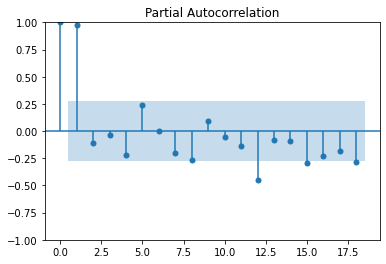

In [10]:
df_train_manual = result_iphone_13_vmanual[:51]
df_test_manual = result_iphone_13_vmanual[-14:]


acf_original = plot_acf(df_train_manual)

pacf_original = plot_pacf(df_train_manual)

In [11]:
adf_test = adfuller(df_train_manual)
print(f'p-value: {adf_test[1]}')

# ADF test suggests our data is non-stationary

p-value: 0.9900087708925223


#### ARIMA - Manual - Doing Differencing

/home/leet23/.local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


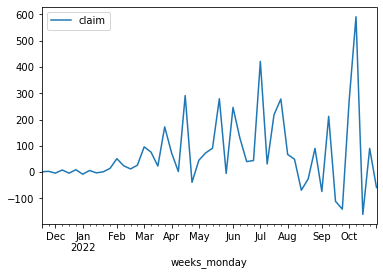

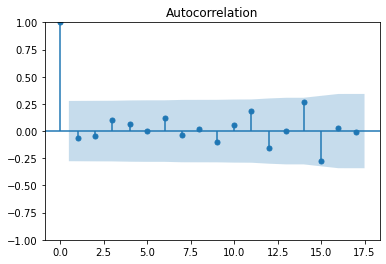

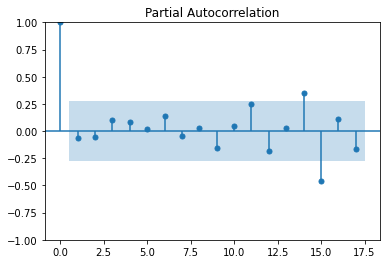

In [12]:
# Use dropna to avoid the first value that appears from doing differncing
df_train_diff = df_train_manual.diff().dropna() 

df_train_diff.plot()

# Repeat by doing the ACF and PACF on the differenced data
acf_diff = plot_acf(df_train_diff) 
pacf_diff = plot_pacf(df_train_diff)

In [13]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

# This suggests that the d = 1
# Given the above graphics, we can conclude through manual arima that it's (0, 1, 0) for (p, d, q)

p-value: 1.4160552973273805e-10


In [14]:
model = ARIMA(df_train_manual, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())

/home/leet23/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/leet23/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/leet23/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   51
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -322.738
Date:                Wed, 29 Mar 2023   AIC                            647.475
Time:                        01:17:59   BIC                            649.387
Sample:                    11-15-2021   HQIC                           648.203
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.366e+04   2789.973      8.480      0.000    1.82e+04    2.91e+04
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                37.45
Prob(Q):                              0.63   Pr

## ARIMA Model - Auto_ARIMA

> The auto_arima calculated values turned out to be (0,1,0) which is the same as the manual arima.

In [15]:
df_train = result_iphone_13[:51]
df_test = result_iphone_13[-14:]

display(df_train)
display(df_test)

,claim
weeks_monday,
2021-11-15,2
2021-11-22,3
2021-11-29,6
2021-12-06,2
2021-12-13,10
2021-12-20,6
2021-12-27,15
2022-01-03,7
2022-01-10,13


,claim
weeks_monday,
2022-11-07,3426
2022-11-14,3335
2022-11-21,3084
2022-11-28,3528
2022-12-05,3291
2022-12-12,3123
2022-12-19,2312
2022-12-26,2616
2023-01-02,3683


In [16]:
auto_arima_v1 = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima_v1

# ARIMA with a (0,1,0) is returned as optimal

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [17]:
auto_arima_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -317.110
Date:                Wed, 29 Mar 2023   AIC                            638.220
Time:                        01:18:02   BIC                            642.045
Sample:                    11-15-2021   HQIC                           639.677
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     69.0600     26.248      2.631      0.009      17.616     120.504
sigma2      1.889e+04   3229.136      5.851      0.000    1.26e+04    2.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                37.45
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):              10.30   Skew:                             1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'iPhone 13 Claims with ARIMA')

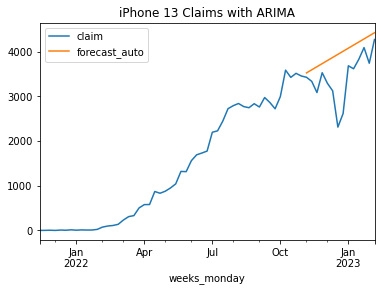

In [18]:
forecast_test_auto = auto_arima_v1.predict(n_periods=len(df_test))

result_iphone_13['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

result_iphone_13.plot()
plt.title("iPhone 13 Claims with ARIMA")

# This graphic shows that the model doesn't work well as the auto arima was the optimal values are (0,1,0)

## Alternative Search of Auto ARIMA - SARIMA

In [19]:
display(result_iphone_13_v2)

,claim
weeks_monday,
2021-11-15,2
2021-11-22,3
2021-11-29,6
2021-12-06,2
2021-12-13,10
...,...
2023-01-09,3616
2023-01-16,3828
2023-01-23,4090


In [20]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(result_iphone_13_v2)

# We still expect to d = 1

(0.4592922983921267, True)

Text(0.5, 1.0, 'iPhone 13 Claims as Train and Test Data')

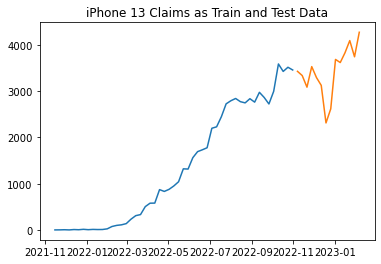

In [21]:
train = result_iphone_13_v2[:51]
test = result_iphone_13_v2[-14:]
# To connect the whole graphic it's -15, but the example online intentionally left a blank

plt.plot(train)
plt.plot(test)
plt.title("iPhone 13 Claims as Train and Test Data")

In [22]:
arima_model = pm.auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5, max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5, max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True, stepwise=True,
          random_state=20, n_fits=50)

# This came back with actually a SARIMA model with (p, d, q,) (P, D, Q)S

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=514.608, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=509.951, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=515.556, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=510.555, Time=0.37 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=508.093, Time=0.10 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=508.808, Time=0.23 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=10622574263.438, Time=0.26 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=10622574261.123, Time=0.27 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=509.948, Time=0.19 sec
 ARIMA(1,1,1)(1,1,0)[12]             

In [23]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   51
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -252.047
Date:                            Wed, 29 Mar 2023   AIC                            508.093
Time:                                    01:18:07   BIC                            511.368
Sample:                                11-15-2021   HQIC                           509.258
                                     - 10-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5489      0.133     -4.118      0.000      -0.810      -0.288
sigma2      3.038e+04   5637.377      5.389      0.000    1.93e+04    4.14e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 2.34
Prob(Q):                              0.47   Prob(JB):                         0.31
Heteroskedasticity (H):               5.96   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 21))
prediction.columns = ['predicted_values']
prediction

# Predicting the next 21 values, which includes all of the data from the test data set and then the additional 

,predicted_values
2022-11-07,3577.016789
2022-11-14,3562.543664
2022-11-21,3738.171880
2022-11-28,3776.147238
2022-12-05,3893.736642
2022-12-12,3867.815959
2022-12-19,4035.297094
2022-12-26,4175.463580
2023-01-02,4561.724321
2023-01-09,4641.690902


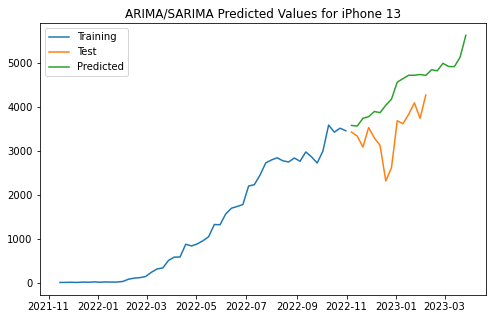

,claim
weeks_monday,
2022-11-07,3426
2022-11-14,3335
2022-11-21,3084
2022-11-28,3528
2022-12-05,3291
2022-12-12,3123
2022-12-19,2312
2022-12-26,2616
2023-01-02,3683


In [25]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA/SARIMA Predicted Values for iPhone 13")
plt.show()

# Displaying our original test data set
display(test)

# Given the ARIMA (0,1,0) model, I think the SARIMA (0,1,0)(1,1,0)[12] would overall work better, especially when exclude
# the final data point

In [26]:
from sklearn.metrics import r2_score
test['predicted_values'] = prediction
r2_score(test['claim'], test['predicted_values'])

# R2 Score for test data set shows that the model didn't do well in testing

/tmp/ipykernel_28412/2936721035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_values'] = prediction


-2.0313873980204855

In [27]:
score = np.sqrt(mean_squared_error(test['claim'], test['predicted_values']))

print(f' RMSE Score on Test set: {score:0.2f}')

 RMSE Score on Test set: 890.02
